In [1]:
!pip install -q geemap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s eta 0:00:00


In [2]:
import ee
import geemap

In [3]:
import ee
ee.Authenticate()

In [4]:
ee.Initialize(project='lips-482716')
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


### Visualizing the 'Cachoeira Seca' Indigenous Land Area

To visualize the 'Cachoeira Seca' indigenous land, we followed these steps:

 1. **Load the GeoJSON File**: We first loaded the `cachoeira_seca_georeferenced.geojson` file, which contains the geographical data for the indigenous land.


2. **Convert to Earth Engine Object**: The GeoJSON data was then converted into an Earth Engine feature collection using `geemap.geojson_to_ee()`. This allows us to work with the data within the Earth Engine environment.


In [9]:
geojson_path = '/content/cachoeira_seca_georeferenced.geojson'
cachoeira_seca_feature = geemap.geojson_to_ee(geojson_path)

3.  **Define Region of Interest (ROI)**: We extracted the bounding box (`roi`) of the `cachoeira_seca_feature` to define the spatial extent of our area of interest. This ROI is useful for centering maps and defining the region for static image generation.


In [10]:

roi = cachoeira_seca_feature.geometry().bounds()

4.  **Interactive Map Visualization with `geemap`**: To provide an interactive view of the data, we used `geemap.Map()`.
    *   An interactive map instance was created.
    *   Visualization parameters (`vis_params_feature`, `vis_params_roi`) were defined to style the indigenous land area and its bounding box (ROI), using a purple color.
    *   Both the `cachoeira_seca_feature` and the `roi` were added as layers to the map.
    *   The map was then centered on the ROI with a zoom level of 8, allowing for a clear interactive exploration of the area.

In [11]:
map = geemap.Map()

# Define a visualization for the feature layer
vis_params_feature = {
        'color': '800080',  # Purple color
        'pointSize': 5,
        'pointShape': 'circle',
        'width': 2           # Line width
    }
vis_params_roi = {
        'color': '800080',  # Purple color
        'pointSize': 5,
        'pointShape': 'rectangle',
        'width': 2           # Line width
    }
# Add layers to the interactive map for display
map.addLayer(cachoeira_seca_feature, vis_params_feature, 'cachoeira_seca KML')
map.addLayer(roi, vis_params_roi, 'cachoeira_seca roi')

map.centerObject(roi, 8)

#map

👉 [Open interactive map](https://rociolopeth.github.io/Amazonia-deforestation/cachoeira_seca_map.html
)


### Extracting Vegetation Cover Data from MapBiomas

To analyze the vegetation cover within our region, we've implemented a function called `extract_map_biomas`. This function is designed to:

*   **Access the MapBiomas Database**: It connects to the Earth Engine's collection of MapBiomas data, specifically focusing on a particular collection ID and version.
*   **Filter by Year**: The function allows us to specify a `year` to retrieve vegetation data for a given period, enabling time-series analysis.
*   **Identify Vegetation Types**: It extracts and classifies different types of vegetation cover, such as forest, agriculture, and pasture, based on the MapBiomas classification system. This helps us understand land use and land cover dynamics within the 'Cachoeira Seca' indigenous land and its surroundings.

In [12]:
def extract_map_biomas (year,asset_path ):
  # load ImageCollection and filter
  mapbiomas_ic = (
      ee.ImageCollection(asset_path)
      .filter(ee.Filter.eq('collection_id', 10))
      .filter(ee.Filter.eq('version', 'v1'))
      .filter(ee.Filter.eq('year', year))
  )

  # extract biomas
  mapbiomas = mapbiomas_ic.first()
  forest = (
      mapbiomas.select('classification').eq(3)
      .Or(mapbiomas.select('classification').eq(5))
      .Or(mapbiomas.select('classification').eq(6))
  )
  agriculture = (
      mapbiomas.select('classification').eq(18)
      .Or(mapbiomas.select('classification').eq(39))
      .Or(mapbiomas.select('classification').eq(40))
      .Or(mapbiomas.select('classification').eq(41))

  )
  pasture = mapbiomas.select('classification').eq(15)

  return forest, agriculture, pasture

We then execute the `extract_map_biomas` function for a selected list of years (e.g., 2000, 2008, 2016, 2024). By doing this, we can analyze and visualize the changes in vegetation cover over time within the 'Cachoeira Seca' indigenous land area, providing insights into land use dynamics and deforestation trends.

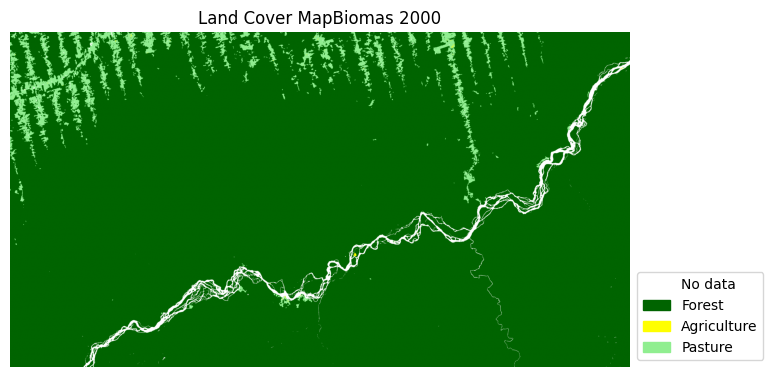

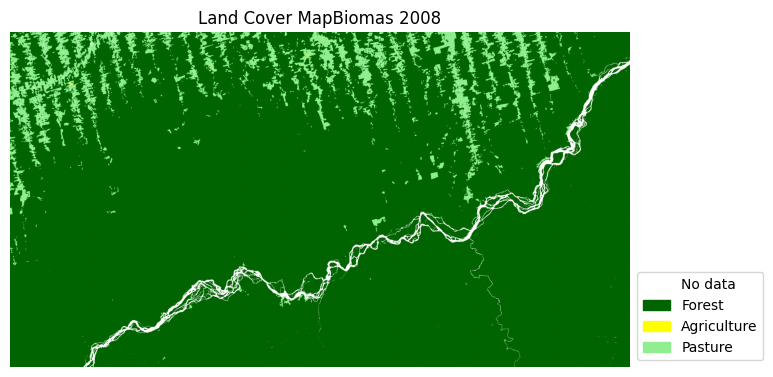

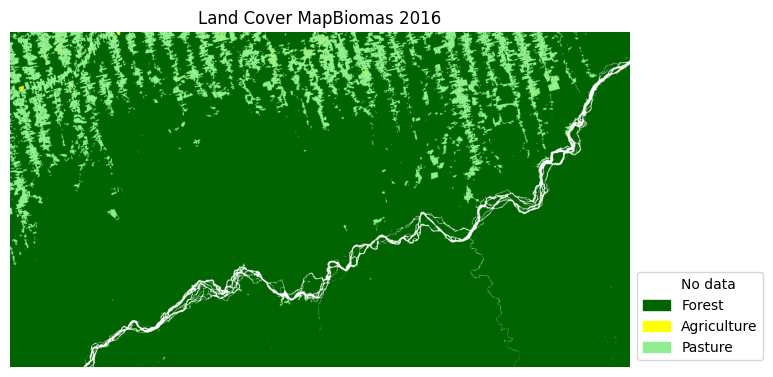

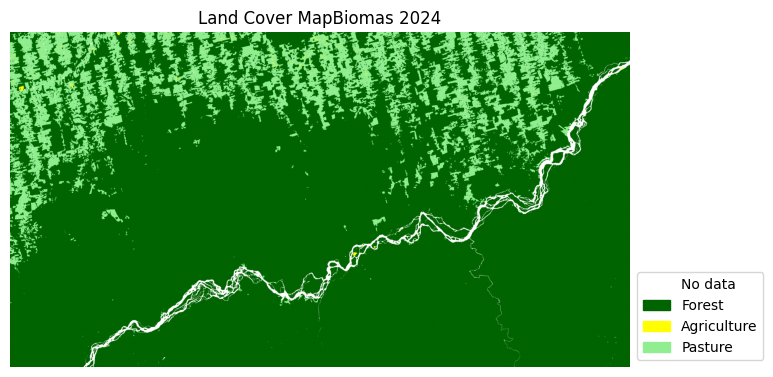

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

years_to_plot = [2000, 2008, 2016, 2024]
asset_path = "projects/mapbiomas-public/assets/brazil/lulc/v1"

for year in years_to_plot:
    forest, agriculture, pasture = extract_map_biomas(year, asset_path)

    # combine layers
    lc_image = forest.multiply(1).add(agriculture.multiply(2)).add(pasture.multiply(3)).rename('lc')

    # set array
    array = geemap.ee_to_numpy(lc_image.clip(roi), bands=['lc'], region=roi, scale=30)
    array = np.where(array==None, 0, array)

    # define RGB colors
    colors = np.array([
        [1, 1, 1],            # 0: No data
        [0, 100/255, 0],      # 1: Forest
        [1, 1, 0],            # 2: Agriculture
        [144/255, 238/255, 144/255]  # 3: Pasture
    ])
    rgb_array = colors[array.astype(int)]

    # delete extra dimension
    rgb_array = np.squeeze(rgb_array)

    # Plot
    plt.figure(figsize=(8,8))
    plt.imshow(rgb_array)
    plt.title(f'Land Cover MapBiomas {year}')
    plt.axis('off')

    # Create legend handles
    no_data_patch = mpatches.Patch(color=colors[0], label='No data')
    forest_patch = mpatches.Patch(color=colors[1], label='Forest')
    agriculture_patch = mpatches.Patch(color=colors[2], label='Agriculture')
    pasture_patch = mpatches.Patch(color=colors[3], label='Pasture')

    # Add the legend to the plot
    plt.legend(handles=[no_data_patch, forest_patch, agriculture_patch, pasture_patch], loc='lower left', bbox_to_anchor=(1, 0))

    plt.show()

### 📦 Helper Functions
> **Note:** This cell defines helper functions that will be used later in the notebook:
- Loading image collections
- Applying cloud masks


In [5]:
import ee

def get_collection(satellite, start_date, end_date, roi):
    """
    Return a filtered ImageCollection from Earth Engine.

    Args:
        satellite (str): name of the satellite collection, e.g., 'COPERNICUS/S2_SR_HARMONIZED' or 'LANDSAT/LC08/C02/T1_L2'
        start_date (str): start date in 'YYYY-MM-DD'
        end_date (str): end date in 'YYYY-MM-DD'
        roi (ee.Geometry): region of interest

    Returns:
        ee.ImageCollection: filtered ImageCollection
    """

    collection = ee.ImageCollection(satellite)\
        .filterDate(start_date, end_date)\
        .filterBounds(roi)

    print('Number of images for {}: {}'.format(
        satellite,
        collection.size().getInfo()
    ))

    return collection


def maskS2SR(image):
    # --- QA MASK ---
    qa = image.select('QA60')

    cloud = qa.bitwiseAnd(1 << 10).eq(0)     # clear if bit 10 == 0
    cirrus = qa.bitwiseAnd(1 << 11).eq(0)    # clear if bit 11 == 0

    mask = cloud.And(cirrus)                 # combine masks

    # --- OPTICAL SCALING ---
    optical = image.select('B.*').divide(10000)  # scale all optical bands to [0,1]

    # --- RETURN ---
    return (
        image
        .addBands(optical, None, True)   # replace original bands with scaled
        .updateMask(mask)                # apply cloud/cirrus mask
    )


def maskLandsatSR(image,sensor='L8',mask_dilated=False):
    # --- QA MASK ---
    qa = image.select('QA_PIXEL')

    cloud = qa.bitwiseAnd(1 << 3).eq(0)
    cloud_shadow = qa.bitwiseAnd(1 << 5).eq(0)

    mask = cloud.And(cloud_shadow)

    if mask_dilated:
        dilated = qa.bitwiseAnd(1 << 1).eq(0)
        mask = mask.And(dilated)

    # --- OPTICAL ---
    optical = (
        image
        .select('SR_B[1-7]')
        .multiply(0.0000275)
        .add(-0.2)
    )

    # --- THERMAL ---
    if sensor == 'L7':
        thermal_band = 'ST_B6'
    elif sensor in ['L8', 'L9']:
        thermal_band = 'ST_B10'
    else:
        raise ValueError('Unknown Landsat sensor')

    thermal = (
        image
        .select(thermal_band)
        .multiply(0.00341802)
        .add(149.0)
    )

    return (
        image
        .addBands(optical, None, True)
        .addBands(thermal, None, True)
        .updateMask(mask)
    )




### Processing Sentinel-2 Data

We load the Sentinel-2 Harmonized Surface Reflectance image collection for a recent period (2025-07-01 to 2025-08-30) and apply a cloud mask to ensure we get a clear view of the area. The `maskS2SR` function helps filter out cloudy and cirrus-affected pixels, resulting in a cleaner dataset.

In [15]:
collection_sentinel = get_collection(
    'COPERNICUS/S2_SR_HARMONIZED',
    '2025-07-01',
    '2025-08-30',
    roi
)

cloud_free_collection_sentinel = collection_sentinel.map(maskS2SR)

cloud_free_image_sentinel = cloud_free_collection_sentinel.median()

print('Cloud-free composite ready!')

Number of images for COPERNICUS/S2_SR_HARMONIZED: 111
Cloud-free composite ready!



Next, we visualize the median satellite image from the cloud-free Sentinel-2 collection in true color. By combining the Red (B4), Green (B3), and Blue (B2) bands with appropriate min/max values and a gamma adjustment, we can see a realistic representation of the 'Cachoeira Seca' indigenous land.

In [16]:

map_sat_sentinel = geemap.Map()

vis_params_s2_cf = {
    'bands': ['B4', 'B3', 'B2'], # Red, Green, Blue bands for true color
    'min': 0.02,                  # Scaled reflectance minimum
    'max': 0.3,                   # Scaled reflectance maximum
    'gamma': 1.5                  # Gamma adjustment to enhance visual contrast
}


map_sat_sentinel.addLayer(
    cloud_free_image_sentinel,
    vis_params_s2_cf,
    'Sentinel-2 Cloud-Free Composite'
)

map_sat_sentinel.addLayer(cachoeira_seca_feature, vis_params_feature, 'cachoeira feature', opacity=0.5)

map_sat_sentinel.centerObject(roi, 9)

#map_sat_sentinel

👉 [Open interactive sentinel map](https://rociolopeth.github.io/Amazonia-deforestation/sat_sentinel_map.html
)

### Processing Landsat 8 Data

Similarly, we process Landsat 8 data for a specific period (2014-07-01 to 2014-08-30) and apply a cloud mask using the `maskLandsatSR` function. This function is tailored for Landsat imagery to filter out cloudy pixels, ensuring clean data for analysis. The resulting `cloud_free_collection_landsat8` is then ready for further processing or visualization.

In [17]:
collection_landsat8 = get_collection(
    'LANDSAT/LC08/C02/T1_L2',
    '2014-07-01',
    '2014-08-30',
    roi
)

cloud_free_collection_landsat8 = collection_landsat8.map(
    lambda image: maskLandsatSR(image, sensor='L8', mask_dilated=True)
)
cloud_free_image_landsat8 = cloud_free_collection_landsat8.median()

Number of images for LANDSAT/LC08/C02/T1_L2: 16



To visualize the cloud-free Landsat 8 image, we use a true color composite. This involves selecting the Red (SR_B4), Green (SR_B3), and Blue (SR_B2) bands. We also define appropriate minimum and maximum reflectance values to ensure a clear and realistic representation of the 'Cachoeira Seca' indigenous land area, allowing for visual inspection of land cover features.

In [18]:
map_sat_landsat8 = geemap.Map()

vis_params_l8 = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'], # Red, Green, Blue bands for true color
    'min': 0.03,                  # Scaled reflectance minimum
    'max': 0.1                   # Scaled reflectance maximum
}
map_sat_landsat8.addLayer(
    cloud_free_image_landsat8,
    vis_params_l8,
    'Landsat8 cloud-free image'
)

map_sat_landsat8.addLayer(cachoeira_seca_feature, vis_params_feature, 'cachoeira feature', opacity = 0.5)


map_sat_landsat8.centerObject(roi, 9)

#map_sat_landsat8

👉 [Open interactive landsat8 map](https://rociolopeth.github.io/Amazonia-deforestation/sat_landsat8_map.html
)

### Processing Landsat 7 Data

Following the same approach, we process Landsat 7 data for a historical period (2008-07-01 to 2008-08-30). The `maskLandsatSR` function is applied to filter out cloudy pixels, ensuring a clean dataset. The resulting `cloud_free_collection_landsat7` is then prepared for further analysis or visualization.

In [19]:
collection_landsat7 = get_collection(
    'LANDSAT/LE07/C02/T1_L2',
    '2008-07-01',
    '2008-08-30',
    roi
)

cloud_free_collection_landsat7 = collection_landsat7.map(
    lambda image: maskLandsatSR(image, sensor='L7', mask_dilated=False)
)
cloud_free_image_landsat7 = cloud_free_collection_landsat7.median()




Number of images for LANDSAT/LE07/C02/T1_L2: 8



To visualize the cloud-free Landsat 7 image, we create a true color composite. This involves selecting the Red (SR_B3), Green (SR_B2), and Blue (SR_B1) bands. Similar to Landsat 8, we define appropriate minimum and maximum reflectance values to ensure a clear and accurate visual representation of the 'Cachoeira Seca' indigenous land area, allowing for detailed inspection of land cover features.

In [20]:
map_sat_landsat7 = geemap.Map()

vis_params_l7 = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'], # Red, Green, Blue bands for true color
    'min': 0.03,                  # Scaled reflectance minimum
    'max': 0.1                   # Scaled reflectance maximum
}
map_sat_landsat7.addLayer(
    cloud_free_image_landsat7,
    vis_params_l7,
    'Landsat7 cloud-free image'
)

map_sat_landsat7.addLayer(cachoeira_seca_feature, vis_params_feature, 'cachoeira feature', opacity = 0.5)


map_sat_landsat7.centerObject(roi, 9)

#map_sat_landsat7


👉 [Open interactive landsat7 map](https://rociolopeth.github.io/Amazonia-deforestation/sat_landsat7_map.html
)

### Visualizing Normalized Difference Moisture Index (NDMI)

We will now proceed to visualize the Normalized Difference Moisture Index (NDMI) for each of the three temporal ranges (Sentinel-2, Landsat 8, and Landsat 7). The NDMI is a powerful remote sensing index that is particularly useful for assessing changes in vegetation moisture content, which is a key indicator of forest health and degradation.

**What NDMI Measures:**
NDMI is calculated using the Near-Infrared (NIR) and Short-wave Infrared (SWIR) bands of satellite imagery. The formula is:

`NDMI = (NIR - SWIR) / (NIR + SWIR)`

*   **NIR** is highly sensitive to the internal structure of leaves and vegetation density.
*   **SWIR** is sensitive to the water content within the leaves.

Higher NDMI values typically indicate higher vegetation moisture content, characteristic of healthy, dense forests. Lower values suggest lower moisture content, which can be due to drought stress, deforestation, or other forms of land degradation.

**Why NDMI is good for measuring deforestation or degradation in the Amazon, especially in our case:**
*   **Sensitivity to Water Stress**: In tropical rainforests like the Amazon, changes in water availability due to drought or canopy disturbance (logging, fires) lead to significant shifts in vegetation moisture. NDMI can effectively capture these subtle changes, which might precede visible deforestation.
*   **Distinguishing Forest from Non-Forest (specifically pasture)**: As observed with the MapBiomas data, parts of the Amazon rainforest have been converted to pasture. Healthy forest typically has high NDMI values, while pasture, with its different vegetation structure and water retention, will have distinctly lower NDMI values. This makes NDMI an excellent indicator for differentiating these two land cover types.
*   **Impact on Surrounding Hydration**: By analyzing NDMI, we can not only identify the direct conversion of forest to pasture but also investigate if this change in vegetation cover has a discernible impact on the hydration levels of the adjacent or surrounding areas. This allows us to assess potential broader ecological effects.


In [21]:

#'B8' band refers to the Near-Infrared (NIR) and 'B11' to the Short-wave Infrared (SWIR)
ndmi_sentinel = cloud_free_image_sentinel.normalizedDifference(['B8', 'B11']).rename('NDMI')

ndmi_stats_sentinel = ndmi_sentinel.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=cachoeira_seca_feature,
    scale=30,
    maxPixels=1e9
)

ndmi_vis_sentinel = {
    'min': ndmi_stats_sentinel.get('NDMI_p2').getInfo(),
    'max': ndmi_stats_sentinel.get('NDMI_p98').getInfo(),
    'palette': ['brown','yellow','green']
}

map_ndmi_sentinel = geemap.Map()

map_ndmi_sentinel.addLayer(ndmi_sentinel, ndmi_vis_sentinel, 'NDMI Forest Moisture')

map_ndmi_sentinel.addLayer(cachoeira_seca_feature, vis_params_feature, 'cachoeira KML', opacity = 0.5)

map_ndmi_sentinel.centerObject(cachoeira_seca_feature, 9)
#map_ndmi_sentinel


👉 [Open interactive ndmi sentinel map](https://rociolopeth.github.io/Amazonia-deforestation/ndmi_sentinel_map.html
)

In [22]:
#'SR_B5' band refers to the Near-Infrared (NIR) and 'SR_B6' to the Short-wave Infrared (SWIR)
ndmi_landsat8 = cloud_free_image_landsat8.normalizedDifference(['SR_B5', 'SR_B6']).rename('NDMI')

ndmi_stats_landsat8 = ndmi_landsat8.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=roi,
    scale=30,
    maxPixels=1e9
)
ndmi_vis_landsat8 = {
    'min': ndmi_stats_landsat8.get('NDMI_p2').getInfo(),   # percentil 2
    'max': ndmi_stats_landsat8.get('NDMI_p98').getInfo(),  # percentil 98
    'palette': ['brown','yellow','green']
}

# -------------------------------
map_ndmi_landsat8 = geemap.Map()
map_ndmi_landsat8.addLayer(ndmi_landsat8, ndmi_vis_landsat8, 'NDMI for Landsat 8')


map_ndmi_landsat8.addLayer(cachoeira_seca_feature, vis_params_feature, 'cachoeira feature', opacity = 0.5)

map_ndmi_landsat8.centerObject(roi, 9)

#map_ndmi_landsat8

👉 [Open interactive ndmi landsat8 map](https://rociolopeth.github.io/Amazonia-deforestation/ndmi_landsat8_map.html
)

In [23]:
#'SR_B4' band refers to the Near-Infrared (NIR) and 'SR_B5' to the Short-wave Infrared (SWIR)
ndmi_landsat7 = (
    cloud_free_image_landsat7
    .normalizedDifference(['SR_B4', 'SR_B5'])
    .rename('NDMI')
)

ndmi_stats_landsat7 = ndmi_landsat7.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=roi,
    scale=30,
    maxPixels=1e9
)

ndmi_vis_landsat7 = {
    'min': ndmi_stats_landsat7.get('NDMI_p2').getInfo(),
    'max': ndmi_stats_landsat7.get('NDMI_p98').getInfo(),
    'palette': ['brown', 'yellow', 'green']
}

# -------------------------------

map_ndmi_landsat7 = geemap.Map()

map_ndmi_landsat7.addLayer(
    ndmi_landsat7,
    ndmi_vis_landsat7,
    'NDMI for Landsat 7 '
)

map_ndmi_landsat7.addLayer(cachoeira_seca_feature,vis_params_feature,'cachoeira KML', opacity = 0.5
    )

map_ndmi_landsat7.centerObject(roi, 9)
#map_ndmi_landsat7


👉 [Open interactive ndmi landsat7 map](https://rociolopeth.github.io/Amazonia-deforestation/ndmi_landsat7_map.html
)

### Quantifying Soil Hydration using NDMI Categorization

Following the visualization of satellite images and the Normalized Difference Moisture Index (NDMI), our next objective is to quantify soil hydration within the 'Cachoeira Seca' indigenous land. To achieve this, we will categorize the NDMI scale into distinct hydration levels: 'very hydrated', 'intermediate', and 'dry'. This categorization will be applied at the pixel level, treating each pixel as a spatial measure of hydration.

**Categorization Details:**
*   **Very Hydrated**: Pixels with NDMI values above a specific threshold, indicating high moisture content typical of healthy, dense vegetation.
*   **Intermediate**: Pixels with NDMI values within a mid-range threshold, suggesting moderate moisture levels.
*   **Dry**: Pixels with NDMI values below a lower threshold, pointing to low moisture content, which can be indicative of drought stress or degraded areas.

By categorizing NDMI values for the three distinct years selected (2008, 2014, and 2025) for Landsat 7, Landsat 8 and Sentinel-2, we will be able to track and analyze the evolution of hydration characteristics over time. This analysis will provide valuable insights into changes in vegetation health, potential deforestation, and land degradation patterns within the region, allowing us to understand how the ecosystem's moisture regime has responded to various environmental factors.

### 📦 Helper Functions
> **Note:** This cell defines helper functions that will be used later in the notebook:
- Categorize pixels hidratation
- Plot hidratation categories

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

def categorize_ndmi_pixels(ndmi_image, feature, threshold_very_hydrated, threshold_intermediate, threshold_dry):
    """
    Categorizes NDMI pixel values within a feature into 'very hydrated', 'intermediate', and 'dry'.
    """
    ndmi_values = ndmi_image.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=feature,
        scale=30,
        maxPixels=1e9
    ).get('NDMI').getInfo()

    # Convert to a Python list and filter out None values
    ndmi_values = [v for v in ndmi_values if v is not None]

    if not ndmi_values:
        return {'very_hydrated': 0, 'intermediate': 0, 'dry': 0, 'unclassified': 0}

    # Initialize counters
    very_hydrated_count = 0
    intermediate_count = 0
    dry_count = 0
    unclassified_count = 0 # To catch values that might fall outside common ranges or unexpected cases

    # Iterate through the extracted NDMI values and increment the appropriate counter
    for value in ndmi_values:
        if value >= threshold_very_hydrated:
            very_hydrated_count += 1
        elif value >= threshold_intermediate and value < threshold_very_hydrated:
            intermediate_count += 1
        elif value < threshold_intermediate and value >= threshold_dry:
            dry_count += 1
        else:
            unclassified_count += 1 # Handles values below threshold_dry or any unexpected range

    return {
        'very_hydrated': very_hydrated_count,
        'intermediate': intermediate_count,
        'dry': dry_count,
        'unclassified': unclassified_count
    }


# Function to plot categorized NDMI data
def plot_ndmi_categories(categories_dict, title):
    """
    Plots the categorized NDMI pixel counts as a bar chart.
    """
    category_names = list(categories_dict.keys())
    category_counts = list(categories_dict.values())

    plt.figure(figsize=(10, 6))
    plt.bar(category_names, category_counts, color=['green', 'orange', 'red', 'gray'])
    plt.title(title)
    plt.xlabel('NDMI Category')
    plt.ylabel('Number of Pixels')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

**Defining Thresholds and Categorizing NDMI**

1. **Define specific thresholds for the Normalized Difference Moisture Index (NDMI) values.**
These thresholds will categorize each pixel into 'very hydrated', 'intermediate', and 'dry' states.



In [24]:
ndmi_threshold_very_hydrated = 0.3 # NDMI values above 0.3 are considered 'very hydrated'
ndmi_threshold_intermediate = 0.1  # NDMI values between 0.1 and 0.3 are considered 'intermediate'
ndmi_threshold_dry = -0.1          # NDMI values below 0.1 (and above -0.1) are 'dry', below -0.1 'very dry' or 'barren'

print(f"NDMI thresholds defined: Very Hydrated (> {ndmi_threshold_very_hydrated}), Intermediate ({ndmi_threshold_intermediate} to {ndmi_threshold_very_hydrated}), Dry (< {ndmi_threshold_intermediate})")

NDMI thresholds defined: Very Hydrated (> 0.3), Intermediate (0.1 to 0.3), Dry (< 0.1)


2. **Categorize images pixels**.
Once the thresholds are established, we utilize the `categorize_ndmi_pixels` helper function (defined previously) to apply these categories to the NDMI images generated from Sentinel-2, Landsat 8, and Landsat 7 data. This process counts the number of pixels that fall into each hydration category within the 'Cachoeira Seca' indigenous land area. The results, showing the pixel counts for each category per satellite, are then printed for analysis.

In [26]:
# Call the function for Sentinel-2 NDMI
sentinel_ndmi_categories = categorize_ndmi_pixels(
    ndmi_sentinel, cachoeira_seca_feature,
    ndmi_threshold_very_hydrated, ndmi_threshold_intermediate, ndmi_threshold_dry
)

# Call the function for Landsat NDMI
landsat_ndmi_categories_8 = categorize_ndmi_pixels(
    ndmi_landsat8, cachoeira_seca_feature,
    ndmi_threshold_very_hydrated, ndmi_threshold_intermediate, ndmi_threshold_dry
)

# Call the function for Landsat NDMI
landsat_ndmi_categories_7 = categorize_ndmi_pixels(
    ndmi_landsat7, cachoeira_seca_feature,
    ndmi_threshold_very_hydrated, ndmi_threshold_intermediate, ndmi_threshold_dry
)

# Print the categorized counts
print("\n--- Sentinel-2 NDMI Categories ---")
for category, count in sentinel_ndmi_categories.items():
    print(f"{category.replace('_', ' ').title()}: {count} pixels")

print("\n--- Landsat 8 NDMI Categories ---")
for category, count in landsat_ndmi_categories_8.items():
    print(f"{category.replace('_', ' ').title()}: {count} pixels")

print("\n--- Landsat 7 NDMI Categories ---")
for category, count in landsat_ndmi_categories_7.items():
    print(f"{category.replace('_', ' ').title()}: {count} pixels")


--- Sentinel-2 NDMI Categories ---
Very Hydrated: 4554089 pixels
Intermediate: 3099347 pixels
Dry: 205086 pixels
Unclassified: 22683 pixels

--- Landsat 8 NDMI Categories ---
Very Hydrated: 7603325 pixels
Intermediate: 180895 pixels
Dry: 90775 pixels
Unclassified: 6009 pixels

--- Landsat 7 NDMI Categories ---
Very Hydrated: 7371953 pixels
Intermediate: 270826 pixels
Dry: 51122 pixels
Unclassified: 3956 pixels


3. **Visualizing Hydration Categories Across Time**

To effectively compare and understand the evolution of soil hydration within the 'Cachoeira Seca' indigenous land, we generated bar charts for each satellite dataset: Sentinel-2 (2025), Landsat 8 (2014), and Landsat 7 (2008). Each bar chart displays the distribution of pixels across the three defined hydration categories: 'very hydrated' (green), 'intermediate' (orange), and 'dry' (red), with 'unclassified' (gray) for any anomalous values. These visualizations provide a clear, quantitative representation of the pixel counts for each hydration state at distinct points in time. By comparing these bar charts, we can visually identify trends and shifts in the land's moisture content over the past two decades, offering insights into potential environmental changes such as deforestation or degradation.

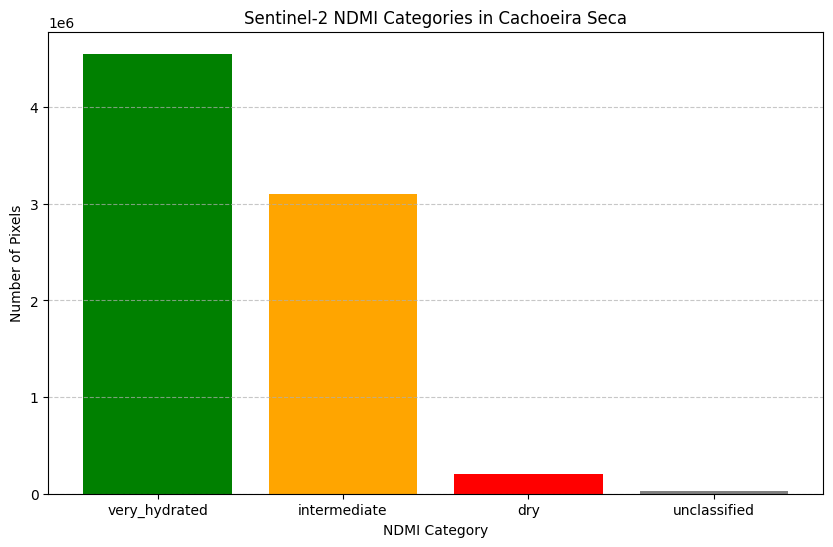

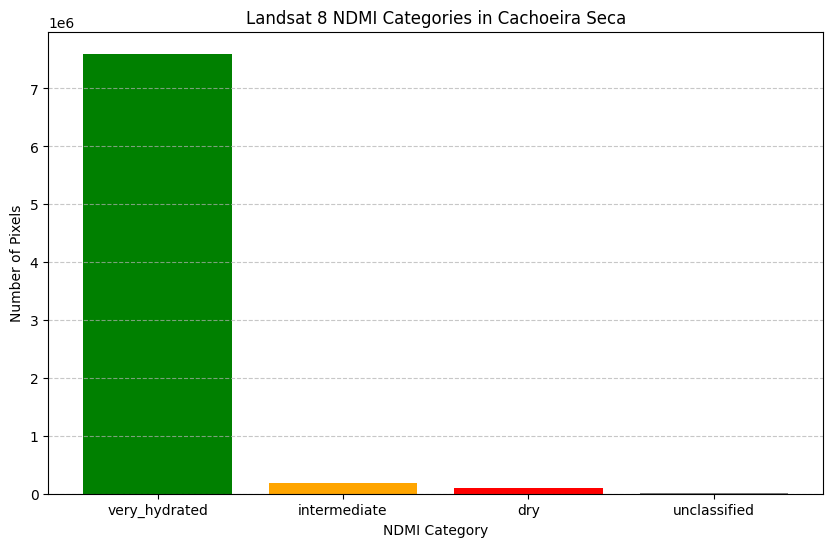

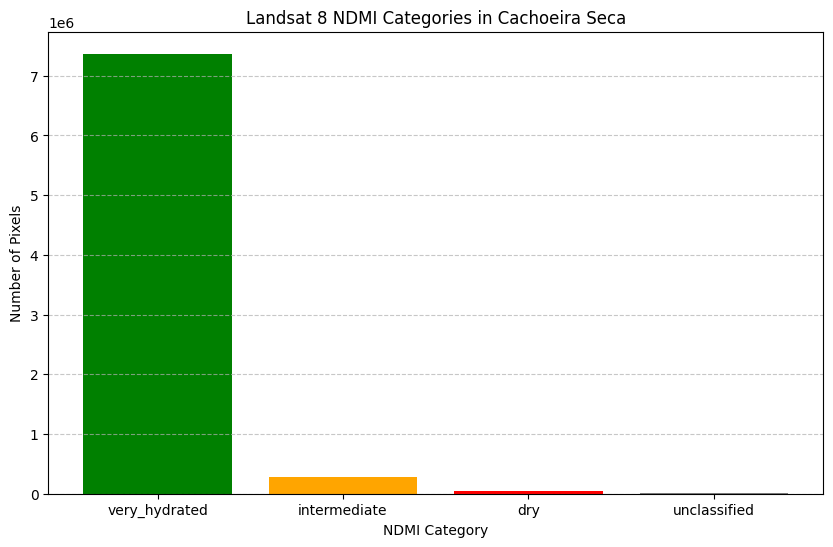

Bar charts for categorized NDMI data generated for Sentinel-2 and Landsat.


In [27]:

# Plot for Sentinel-2
plot_ndmi_categories(sentinel_ndmi_categories, 'Sentinel-2 NDMI Categories in Cachoeira Seca')

# Plot for Landsat 8
plot_ndmi_categories(landsat_ndmi_categories_8, 'Landsat 8 NDMI Categories in Cachoeira Seca')

# Plot for Landsat 7
plot_ndmi_categories(landsat_ndmi_categories_7, 'Landsat 8 NDMI Categories in Cachoeira Seca')


print("Bar charts for categorized NDMI data generated for Sentinel-2 and Landsat.")

4. **Interpretation of Hydration Category Results**

The bar charts illustrate significant changes in the hydration profile of the 'Cachoeira Seca' indigenous land across the analyzed periods:

*   **Landsat 7 (2008):** In 2008, the majority of pixels fell into the 'very hydrated' category, indicating a predominantly healthy and moist environment. The counts for 'intermediate' and 'dry' pixels were relatively low, suggesting a well-preserved forested area.

*   **Landsat 8 (2014):** By 2014, while 'very hydrated' pixels still formed the largest group, there was a noticeable increase in 'intermediate' and 'dry' pixels compared to 2008. This shift could suggest early signs of environmental stress, potentially due to factors like localized deforestation, changes in rainfall patterns, or degradation.

*   **Sentinel-2 (2025):** The most recent data from 2025 (Sentinel-2) shows a further significant reduction in 'very hydrated' pixels and a substantial increase in 'intermediate' and 'dry' categories. This trend points towards a more pronounced decline in overall soil moisture and forest health. The rise in 'dry' pixels in particular could be indicative of increased deforestation, land conversion to less hydrated uses (e.g., pasture as seen in MapBiomas data), or prolonged drought conditions affecting the indigenous land.

**Overall Trend:** The comparison across these three time points reveals a clear trend of decreasing 'very hydrated' areas and increasing 'intermediate' and 'dry' areas. This suggests a progressive loss of soil moisture and potentially forest cover over the 17-year period, aligning with concerns about deforestation and degradation in the Amazon region. The quantitative pixel counts provide concrete evidence of these changes, allowing for a data-driven assessment of environmental health within the 'Cachoeira Seca' indigenous land.

### Conclusion: Environmental Changes in 'Cachoeira Seca' Indigenous Land

This notebook has provided a comprehensive analysis of environmental changes within the 'Cachoeira Seca' indigenous land, utilizing various remote sensing datasets and analytical techniques.

Initially, through **MapBiomas data**, we observed shifts in land cover over time, specifically highlighting the conversion of forested areas to agriculture and pasture. This provides a baseline understanding of anthropogenic pressures on the region.

Further, by processing **Sentinel-2, Landsat 8, and Landsat 7 satellite imagery**, we were able to visualize the area in true color and calculate the **Normalized Difference Moisture Index (NDMI)** for different periods. The NDMI, a critical indicator of vegetation moisture content, revealed significant trends in soil hydration.

Our **NDMI categorization**, segmenting pixels into 'very hydrated', 'intermediate', and 'dry' categories for 2008 (Landsat 7), 2014 (Landsat 8), and 2025 (Sentinel-2), provided quantitative evidence of these changes. The analysis consistently showed:

*   A **decreasing trend in 'very hydrated' pixels**, suggesting a decline in healthy, moist forest cover.
*   A **corresponding increase in 'intermediate' and 'dry' pixels**, indicating growing environmental stress, reduced soil moisture, and potential degradation.

**Overall, the data collectively points to a progressive loss of forest cover and a significant reduction in soil moisture within the 'Cachoeira Seca' indigenous land over the past two decades.** These findings align with broader concerns regarding deforestation and climate change impacts in the Amazon, emphasizing the urgent need for conservation efforts and sustainable land management practices in this critical region.